## Фильтр Блума со счетом

In [8]:
import math
import random
import matplotlib.pyplot as plt
from collections import defaultdict

class CountingBloomFilter:
    def __init__(self, size, number_hash_functions):
        self.size = size
        self.number_hash_functions = number_hash_functions
        self.counters = [0] * size
        self.seeds = [random.randint(0, 999999) for _ in range(number_hash_functions)]
    
    def __hash_djb2(self, s, seed):
        """Хеш-функция DJB2 с добавлением seed для разных хешей"""
        hash_value = 5381 + seed
        for x in s:
            hash_value = ((hash_value << 5) + hash_value) + ord(x)
        return hash_value % self.size
    
    def add_to_filter(self, item):
        """Добавление элемента в фильтр"""
        for i in range(self.number_hash_functions):
            index = self.__hash_djb2(item, self.seeds[i])
            self.counters[index] += 1
    
    def remove(self, item):
        """Удаление элемента из фильтра"""
        for i in range(self.number_hash_functions):
            index = self.__hash_djb2(item, self.seeds[i])
            if self.counters[index] > 0:
                self.counters[index] -= 1
    
    def check(self, item):
        """Проверка наличия элемента в фильтре"""
        for i in range(self.number_hash_functions):
            index = self.__hash_djb2(item, self.seeds[i])
            if self.counters[index] == 0:
                return False
        return True
    
    def union(self, other):
        """Объединение с другим фильтром Блума"""
        if self.size != other.size or self.number_hash_functions != other.number_hash_functions:
            raise ValueError("Фильтры должны иметь одинаковый размер и количество хэш функций")
        
        new_filter = CountingBloomFilter(self.size, self.number_hash_functions)
        new_filter.counters = [a + b for a, b in zip(self.counters, other.counters)]
        return new_filter
    
    def intersection(self, other):
        """Пересечение с другим фильтром Блума"""
        if self.size != other.size or self.number_hash_functions != other.number_hash_functions:
            raise ValueError("Фильтры должны иметь одинаковый размер и количество хэш функций")
        
        new_filter = CountingBloomFilter(self.size, self.number_hash_functions)
        new_filter.counters = [min(a, b) for a, b in zip(self.counters, other.counters)]
        return new_filter

In [ ]:
def calculate_false_positive_rate(filter, test_items, existing_items):
    """Вычисление процента ложноположительных срабатываний"""
    false_positives = 0
    for item in test_items:
        if item not in existing_items and filter.check(item):
            false_positives += 1
    return false_positives / len(test_items)

def test_false_positives(size_range, hash_range, num_elements=1000, num_tests=1000):
    """Тестирование ложноположительных срабатываний для разных параметров"""
    results = defaultdict(list)
    
    for size in size_range:
        for num_hashes in hash_range:
            # Генерация тестовых данных
            existing_items = [str(i) for i in range(num_elements)]
            test_items = [str(i + num_elements) for i in range(num_tests)]
            
            # Создание и заполнение фильтра
            cbf = CountingBloomFilter(size, num_hashes)
            for item in existing_items:
                cbf.add_to_filter(item)
            
            # Измерение ложноположительных срабатываний
            fp_rate = calculate_false_positive_rate(cbf, test_items, existing_items)
            results['size'].append(size)
            results['hashes'].append(num_hashes)
            results['fp_rate'].append(fp_rate)
            
            # Тестирование после удалений
            for _ in range(num_elements // 2):
                item = random.choice(existing_items)
                cbf.remove(item)
            
            fp_rate_after = calculate_false_positive_rate(cbf, test_items, existing_items)
            results['fp_rate_after'].append(fp_rate_after)
    
    return results

def plot_results(results):
    """Визуализация результатов анализа с корректными подписями"""
    plt.figure(figsize=(15, 5))
    
    # 1. Зависимость от размера фильтра
    plt.subplot(1, 2, 1)
    sizes = sorted(set(results['size']))
    
    # Группируем данные по размерам фильтра
    fp_before = defaultdict(list)
    fp_after = defaultdict(list)
    for size, before, after in zip(results['size'], results['fp_rate'], results['fp_rate_after']):
        fp_before[size].append(before)
        fp_after[size].append(after)
    
    # Вычисляем средние значения и доверительные интервалы
    avg_before = [np.mean(fp_before[size]) for size in sizes]
    std_before = [np.std(fp_before[size]) for size in sizes]
    avg_after = [np.mean(fp_after[size]) for size in sizes]
    std_after = [np.std(fp_after[size]) for size in sizes]
    
    # Построение графиков с областями отклонений
    plt.plot(sizes, avg_before, 'b-', label='До удалений', marker='o')
    plt.fill_between(sizes, 
                    [avg_before[i] - std_before[i] for i in range(len(sizes))],
                    [avg_before[i] + std_before[i] for i in range(len(sizes))],
                    color='blue', alpha=0.1)
    
    plt.plot(sizes, avg_after, 'r--', label='После удалений', marker='s')
    plt.fill_between(sizes,
                    [avg_after[i] - std_after[i] for i in range(len(sizes))],
                    [avg_after[i] + std_after[i] for i in range(len(sizes))],
                    color='red', alpha=0.1)
    
    plt.xlabel('Размер фильтра (биты)')
    plt.ylabel('Вероятность ложноположительных срабатываний')
    plt.title('Зависимость вероятности ложноположительных срабатываний\nот размера фильтра')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    
    # 2. Зависимость от количества хеш-функций
    plt.subplot(1, 2, 2)
    hashes = sorted(set(results['hashes']))
    
    # Группируем данные по количеству хеш-функций
    fp_before_hash = defaultdict(list)
    fp_after_hash = defaultdict(list)
    for h, before, after in zip(results['hashes'], results['fp_rate'], results['fp_rate_after']):
        fp_before_hash[h].append(before)
        fp_after_hash[h].append(after)
    
    # Вычисляем средние значения
    avg_before_hash = [np.mean(fp_before_hash[h]) for h in hashes]
    std_before_hash = [np.std(fp_before_hash[h]) for h in hashes]
    avg_after_hash = [np.mean(fp_after_hash[h]) for h in hashes]
    std_after_hash = [np.std(fp_after_hash[h]) for h in hashes]
    
    # Построение графиков
    plt.plot(hashes, avg_before_hash, 'g-', label='До удалений', marker='^')
    plt.fill_between(hashes,
                    [avg_before_hash[i] - std_before_hash[i] for i in range(len(hashes))],
                    [avg_before_hash[i] + std_before_hash[i] for i in range(len(hashes))],
                    color='green', alpha=0.1)
    
    plt.plot(hashes, avg_after_hash, 'm--', label='После удалений', marker='d')
    plt.fill_between(hashes,
                    [avg_after_hash[i] - std_after_hash[i] for i in range(len(hashes))],
                    [avg_after_hash[i] + std_after_hash[i] for i in range(len(hashes))],
                    color='magenta', alpha=0.1)
    
    plt.xlabel('Количество хеш-функций')
    plt.ylabel('Вероятность ложноположительных срабатываний')
    plt.title('Зависимость вероятности ложноположительных срабатываний\nот количества хеш-функций')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
def optimal_parameters(n, p):
    """Вычисление оптимальных параметров по заданным n и p"""
    m = math.ceil(-(n * math.log(p)) / (math.log(2) ** 2))
    k = math.ceil((m / n) * math.log(2))
    return int(m), k

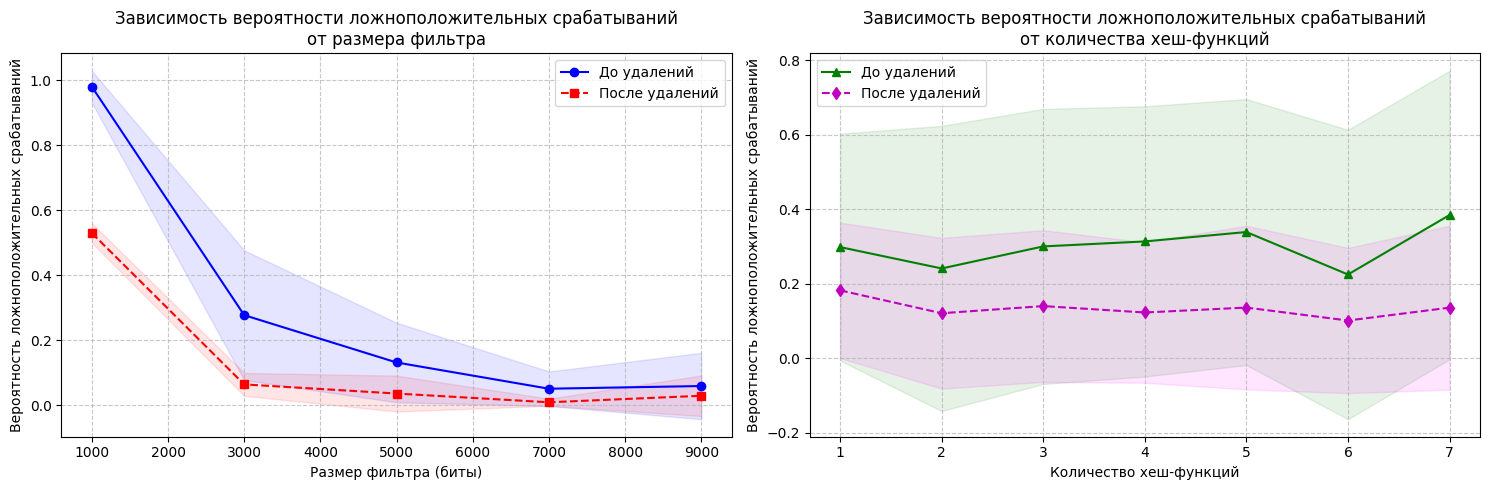


Оптимальные параметры для n=10000, p=0.01:
Размер фильтра: 95851
Количество хеш-функций: 7

Проверка элементов:
'apple': Есть (ожидается: Есть)
'banana': Есть (ожидается: Есть)
'grape': Нет (ожидается: Нет)
'melon': Нет (ожидается: Нет)
'pear': Нет (ожидается: Нет)

После удаления 'apple':
'apple': Нет (может быть ложноположительный)


In [15]:
# Параметры для тестирования
size_range = range(1000, 10001, 2000)
hash_range = range(1, 8)

# Тестирование
results = test_false_positives(size_range, hash_range)

# Визуализация результатов
plot_results(results)

# Пример вычисления оптимальных параметров
n = 10000  # Ожидаемое количество элементов
p = 0.01   # Желаемая вероятность ложноположительных
optimal_size, optimal_hashes = optimal_parameters(n, p)
print(f"\nОптимальные параметры для n={n}, p={p}:")
print(f"Размер фильтра: {optimal_size}")
print(f"Количество хеш-функций: {optimal_hashes}")

# Создание фильтра с оптимальными параметрами
cbf = CountingBloomFilter(optimal_size, optimal_hashes)

# Демонстрация работы
items = ["apple", "banana", "cherry", "date", "elderberry"]
for item in items:
    cbf.add_to_filter(item)

print("\nПроверка элементов:")
test_items = ["apple", "banana", "grape", "melon", "pear"]
for item in test_items:
    print(f"'{item}': {'Есть' if cbf.check(item) else 'Нет'} (ожидается: {'Есть' if item in items else 'Нет'})")

# Тестирование удаления
cbf.remove("apple")
print("\nПосле удаления 'apple':")
print(f"'apple': {'Есть' if cbf.check('apple') else 'Нет'} (может быть ложноположительный)")